In [ ]:
import os
from google.colab import drive

# 1. Drive'ı Bağla (Zaten bağlıysa hata vermez)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Kısayol eklediğin için artık bu yol geçerli olacak
zip_yolu = "/content/drive/MyDrive/Ara Proje/bus_uclm_separated.zip"
hedef_klasor = "/content/bus_uclm_data"

if os.path.exists(zip_yolu):
    !unzip -q "{zip_yolu}" -d "{hedef_klasor}"
    print("✅ SONUNDA! Dosya bulundu ve zipten çıkarıldı.")

    # Sayıları kontrol edelim
    print("\n--- Sınıf Dağılımı ---")
    for root, dirs, files in os.walk(hedef_klasor):
        images = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            print(f"Klasör: {os.path.basename(root)} | Sayı: {len(images)}")
else:
    print("❌ Kısayol ekledin mi? Sol panelde 'Ara Proje'yi görebiliyor musun?")

Mounted at /content/drive
✅ SONUNDA! Dosya bulundu ve zipten çıkarıldı.

--- Sınıf Dağılımı ---
Klasör: benign | Sayı: 174
Klasör: normal | Sayı: 419
Klasör: malign | Sayı: 90


In [ ]:
import os

# Gerçekten resimlerin olduğu klasörleri bulalım
for root, dirs, files in os.walk("/content/bus_uclm_data"):
    if len(files) > 0 and not any(d in root for d in ['.ipynb_checkpoints', '__MACOSX']):
        print(f"Resimlerin bulunduğu yol: {root} | Dosya sayısı: {len(files)}")

Resimlerin bulunduğu yol: /content/bus_uclm_data/bus_uclm_separated/benign | Dosya sayısı: 174
Resimlerin bulunduğu yol: /content/bus_uclm_data/bus_uclm_separated/normal | Dosya sayısı: 419
Resimlerin bulunduğu yol: /content/bus_uclm_data/bus_uclm_separated/malign | Dosya sayısı: 90


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os

# 1. DOĞRU VERİ YOLU
DATA_PATH = "/content/bus_uclm_data/bus_uclm_separated"

# 2. VERİ YÜKLEYİCİ (Augmentation YOK, Sadece Rescale 1./255)
# BUS-UCLM veri seti toplam 683 resimden oluşur.
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 3. MODELİ YÜKLE VE AGRESİF ADAPTASYON AYARLA
# Orijinal modeli Drive'dan çekiyoruz
model = load_model("/content/drive/MyDrive/nasnet_source_model.keras")

# Katmanları dondurma stratejisini güncelledik:
# Son 50 katmanı eğitime açıyoruz (Önceki 15 yetersiz kalmıştı)
for layer in model.layers[:-50]:
    layer.trainable = False

# Learning Rate'i 0.0001 (1e-4) yaptık.
# Modelin %32'lik "kör noktadan" hızlıca çıkması için bu şart.
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. EĞİTİMİ BAŞLAT
print("\n--- BUS-UCLM Agresif Domain Adaptation Başlıyor ---")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

# 5. MODELİ KAYDET (Eski modelin üstüne yazmaz, yeni dosya oluşturur)
save_path = "/content/drive/MyDrive/nasnet_uclm_adapted.keras"
model.save(save_path)
print(f"\n✅ BUS-UCLM Uyarlanmış Model Kaydedildi: {save_path}")

Found 548 images belonging to 3 classes.
Found 135 images belonging to 3 classes.

--- BUS-UCLM Domain Adaptation Başlıyor ---
Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 568s 15s/step - accuracy: 0.2545 - loss: 5.4491 - val_accuracy: 0.3111 - val_loss: 4.9411
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 465s 13s/step - accuracy: 0.2232 - loss: 5.3428 - val_accuracy: 0.3111 - val_loss: 4.7946
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 467s 13s/step - accuracy: 0.2048 - loss: 5.2537 - val_accuracy: 0.3111 - val_loss: 4.6584
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 470s 13s/step - accuracy: 0.2677 - loss: 5.0548 - val_accuracy: 0.3111 - val_loss: 4.5198
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 514s 15s/step - accuracy: 0.2542 - loss: 5.1720 - val_accuracy: 0.3111 - val_loss: 4.3839
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 461s 13s/step - accuracy: 0.2729 - loss: 4.3991 - val_accuracy: 0.3111 - val_loss: 4.2520
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 460s 13s/step - accuracy: 0.2322 - loss: 4.5780 - val_accuracy: 0.3


--- Tahminler Hesaplanıyor (Test Seti) ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step


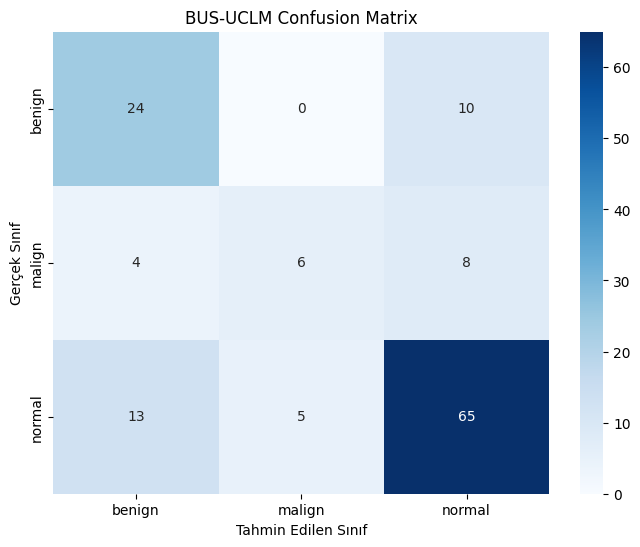


--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      benign       0.59      0.71      0.64        34
      malign       0.55      0.33      0.41        18
      normal       0.78      0.78      0.78        83

    accuracy                           0.70       135
   macro avg       0.64      0.61      0.61       135
weighted avg       0.70      0.70      0.70       135

Genel Doğruluk (Accuracy): %70.37
Genel F1-Skoru: %69.78


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Tahminleri Al
print("\n--- Tahminler Hesaplanıyor (Test Seti) ---")
# Validation generator shuffle=False olduğu için sıralama bozulmaz
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1) # En yüksek olasılıklı sınıfı seç
y_true = val_gen.classes # Gerçek sınıflar

# 2. Confusion Matrix (Karmaşıklık Matrisi) Oluştur
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_gen.class_indices.keys()) # ['benign', 'malign', 'normal']

# 3. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('BUS-UCLM Confusion Matrix')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# 4. Classification Report (Precision, Recall, F1)
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Genel Özet Metrikleri
from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
print(f"Genel F1-Skoru: %{f1*100:.2f}")